**Gustavo Espinosa** &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;   <img src= "https://i0.wp.com/immap.org/wp-content/uploads/2016/12/immap-logo-strap2.png?resize=300%2C45&ssl=1"> <br />
Last updated: July 22th, 2020


# Analisis de asentamientos

<br />

**GitHub Project Card:** 
https://github.com/ghespinosa/iMMAPColombia/projects/1#card-42450092

**OVERVIEW:** 
- Cleans Validation and Monitoring databases
	- removes missing data
	- merges/renames settlements as appropriate
	- sorts alphabetically by settlement
- Explores data
	- identifies unique settlements
	- reverse geocodes coordinates to add departamental/municipal information
	- counts number of surveys for validation and monitoring for each settlement
	- displays key statistics for each settlement
- Prepares various matrices
	- identifies unique columns (by removing numbers from column names)
	- creates master dictionary of each unique column and each unique value
	- categorizes different kinds of columns/variables
- Generates matrices
	- fills element matrix with each settlement and each response to each unique element
	- fills polichotomous variables matrix with variables like 'Existe: si o no', etc.
	- fills foto matrix with all the photos from each settlement
- Photo download and organization
	- fills elem_foto_pair with pairs of photos and the corresponding element
	- puts these elem_foto_pairs into generated folders
	- does the above again but adds an empty validation variable for each pair
	- prompts the user to validate the element photo pairs
- Misc
	- identifies settlements with low quantity of responses
	- identifies settlements that potentially do not exist


**TO-DO:**
- decide on threshold values (for number of responses and for each of the elements, reliability coding)
- generate graphics for each settlement
- create widget for validation/reliability check of the photos
- track surveyor ID in the master_matrix
- create final standard master matrix

See: https://github.com/ghespinosa/proyectoasentamiento

## Import libraries

In [1]:
#Import packages, libraries, etc.

import pandas as pd
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

#directory management
import pathlib
import shutil

#image handling
import matplotlib.image as mpimg
from PIL import Image
import urllib
#import urllib.request
from skimage import io

#Import reverse geocoding libraries
import sys
!{sys.executable} -m pip install geopy

import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

#be able to display two dfs next to each other, or one after the other
from IPython.display import display, HTML

  Using cached geopy-2.0.0-py3-none-any.whl (111 kB)
  Using cached geographiclib-1.50-py3-none-any.whl (38 kB)


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

## Data preprocessing

In [3]:
# Import data

raw_validES = pd.read_csv("ValidationES.csv")
raw_monitES = pd.read_csv("MonitoringES.csv")


In [4]:
# Prep data (remove missing rows)

# Prep data (remove missing rows)

validES=raw_validES
validES=validES.drop(index=0).reset_index(drop=True) #get rid of that first row that's just the title again

monitES=raw_monitES
monitES=monitES.drop(index=0).reset_index(drop=True) #get rid of that first row that's just the title again



In [6]:
#drop rows and columns of data without any data AND sort
validES = validES.dropna(axis=0,how='all').sort_values(by=['location_name']).reset_index(drop=True)
monitES = monitES.dropna(axis=0,how='all').sort_values(by=['location_name']).reset_index(drop=True)
validES = validES.dropna(axis=1,how='all').sort_values(by=['location_name'])
monitES = monitES.dropna(axis=1,how='all').sort_values(by=['location_name'])
monitES.shape

(110, 365)

In [7]:
#If necessary, use SettlementMerger to update validES and monitES to reflect multiple settlements turning out to be one,
    #using overlap in possible name as a guide for what the joint settlment should be named

def SettlementMerger(Sett1,Sett2,Sett3='',NewName=''):
    
    """ 
    |Summary Line  
    | 
    |Description of Function:
    |-----------
    |Merges two or three settlements into one with NewName.
    | if only two arguments are passed, merges two.
    | if three are passed, merges three.
    |
    |
    |Parameters: 
    |-----------
    |Sett1 (str): name of first original settlement to be merged
    |Sett2 (str): name of second original settlement to be merged
    |Sett3 (str): name of third original settlement to be merged, default is passed a blank
    |NewName (str): name you want to assign the new merged seetlement, default simply concats them with +
    |
    |Returns: 
    |-----------
    |DF3 (DataFrame): DataFrame with two original DFs merged along ON (and leaves original DFs unchanged)
    |
    """
    
    if(Sett3==''):
        if(NewName==''):
            NewName=(Sett1 + " _ " + Sett2)
        for i in range(0,len(validES)):
            if ((validES.loc[i,'location_name']==Sett1) | (validES.loc[i,'location_name']== Sett2)):
                validES.loc[i,'location_name']=NewName
                
        for i in range(0,len(monitES)):
            if ((monitES.loc[i,'location_name']==Sett1) | (monitES.loc[i,'location_name']== Sett2)):
                monitES.loc[i,'location_name']=NewName

            
    else:
        if(NewName==''):
            NewName=(Sett1 + " _ " + Sett2 + " _ " + Sett3)
        
        for i in range(0,len(validES)):
            if ((validES.loc[i,'location_name']==Sett1) | (validES.loc[i,'location_name']== Sett2) | (validES.loc[i,'location_name']== Sett3)):
                validES.loc[i,'location_name']=NewName
                
        for i in range(0,len(monitES)):
            if ((monitES.loc[i,'location_name']==Sett1) | (monitES.loc[i,'location_name']== Sett2) | (monitES.loc[i,'location_name']== Sett3)):
                monitES.loc[i,'location_name']=NewName

In [8]:
#(e.g. Liliana's email)

#Maicao:
#- Maicao 14 y Maicao 15
#- Maicao 21 y Maicao 22

#Norte de Santander:
#- Cúcuta 7 y 6 de Reyes
#- Cúcuta 8 y Alfonso Lopez
#- Cúcuta 9, Cúcuta 10 y El Talento
#- Tibú 1 y Tibú 2 (no tenemos datos de Premise)
#- Tibú 3 y Tibú 4 (no tenemos datos de Premise)

SettlementMerger('Maicao 14','Maicao 15',NewName='La Torre De La Majayura 2')
SettlementMerger('Maicao 21','Maicao 22',NewName='La Primavera')
SettlementMerger('Cucuta 7','6 de Reyes',NewName='Seis de Reyes')
SettlementMerger('Cucuta 8','Alfonso López',NewName='Alfonso Gomez')
SettlementMerger('Cucuta 9','Cucuta 10','El Talento',NewName = 'El Talento Sector La Flor')
#SettlementMerger('Tibu 1','Tibu 2',NewName='Tibu 1 y 2') #we don't have premise data for these
#SettlementMerger('Tibu 3','Tibu 4',NewName='Tibu 3 y 4') #we don't have premise data for these

In [9]:
# Consolidate data

#sort again
validES = validES.sort_values(by=['location_name']).reset_index(drop=True)
monitES = monitES.sort_values(by=['location_name']).reset_index(drop=True)
validES = validES.sort_values(by=['location_name'])
monitES = monitES.sort_values(by=['location_name'])

valid_settlements = validES['location_name']
monit_settlements = monitES['location_name']

valid_uq_settlements = valid_settlements.unique()
monit_uq_settlements = monit_settlements.unique()

settlements = [*valid_uq_settlements,*monit_uq_settlements] #explode the unique arrays and 
settlements = pd.Series(data=settlements) #turn it into a pd Series so I can manage it easier
uq_settlements = settlements.unique()

In [10]:
# Display both validation and monitoring data frames one after the other

    #CSS = """
    #.output {
    #    flex-direction: row;
    #}
    #"""

    #HTML('<style>{}</style>'.format(CSS))
    
print("Validation ES")
display(validES)
print("\n Monitoring ES")
display(monitES)

Validation ES


,form_id,submission_id,locale,location_id,location_name,location_centroid,1. Por favor tome una foto del asentamiento,2. Por favor tome una foto del asentamiento desde un ángulo diferente,3. Por favor tome una foto del asentamiento desde un ángulo diferente,4. Por favor tome una foto del asentamiento desde un ángulo diferente,...,9.22 Seleccione el aspecto de la comunidad que está reportando,10.22 Díganos desde qué lugar esta reportando este elemento,11.22 Por favor tome una foto del elemento que está reportando,15. ¿El material de construcción de las viviendas parece ser improvisado?,16. ¿Las casas tienen puertas?,17. ¿De qué materiales están hechas las viviendas principalmente?,18. Por favor tome una fotografía afuera de una vivienda o grupo de viviendas que nos permita entender mejor el tipo de material y cómo están construidas.,19. ¿Sabe el nombre de este asentamiento?,20. Por favor escriba el nombre de este asentamiento,21. ¿Los residentes actuales del asentamiento son colombianos?
0,5306469803360256,5724415935643648,ES,129468,Alfonso Gomez,"7.9137219596446675,-72.545011018832511",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,...,NaN,NaN,NaN,Si,Algunas de las casas tienen puertas,Madera | Latón | Metal corrugado | Ladr...,http://storage.googleapis.com/prod-premise-and...,Si,Alfonso Gómez 2,Hay una mezcla de residentes colombianos y res...
1,5306469803360256,6168468443627520,ES,129468,Alfonso Gomez,"7.9137219596446675,-72.545011018832511",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,...,NaN,NaN,NaN,Si,"Si, todas las casas tienen puertas",Madera,http://storage.googleapis.com/prod-premise-and...,No,NaN,"Si, hay más colombianos que residentes de otro..."
2,5306469803360256,5396129623834624,ES,129468,Alfonso Gomez,"7.9137219596446675,-72.545011018832511",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,...,NaN,NaN,NaN,Si,Algunas de las casas tienen puertas,Madera,http://storage.googleapis.com/prod-premise-and...,No,NaN,No estoy seguro
3,5306469803360256,6522029530677248,ES,129523,Alfonso Gomez,"7.9134336414954918,-72.5464891155506",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,...,NaN,NaN,NaN,Si,"Si, todas las casas tienen puertas",Madera,http://storage.googleapis.com/prod-premise-and...,Si,Alfonso Gomez,"Si, hay más colombianos que residentes de otro..."
4,5306469803360256,5.75009E+15,ES,129523,Alfonso Gomez,"7.9134336414954918,-72.5464891155506",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,...,NaN,NaN,NaN,Si,Algunas de las casas tienen puertas,Madera | Latón | Ladrillo,http://storage.googleapis.com/prod-premise-and...,Si,Alfonso Gómez,Hay una mezcla de residentes colombianos y res...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,5306469803360256,6600421626085376,ES,129460,Uribia-5,"11.705499001367256,-72.26079557354474",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,...,NaN,NaN,NaN,Si,Algunas de las casas tienen puertas,Plástico corrugado,http://storage.googleapis.com/prod-premise-and...,Si,Walijiou,Hay una mezcla de residentes colombianos y res...
220,5306469803360256,574006


 Monitoring ES


,form_id,submission_id,locale,location_id,location_name,location_centroid,1.1 Seleccione el aspecto de la comunidad que está reportando,2.1 Díganos desde qué lugar está reportando ete elemento,3.1 Por favor tome una fotografía del elemento que está reportando,4.1 Los establecimientos de venta de alimentos y abarrotes son en su mayoría:,...,16.30 ¿ Cuántas construcciones (viviendas) nuevas percibe que hay?,"17.30 ¿El Asentamiento cuenta con algún espacio comunitario para la transformación adecuada de los productos alimenticios para consumo, como cocinas comunitarias o comedores?",18. ¿Cuál es la capacidad de dichas cocinas comunitarias o comedores?,19. ¿Cuánto tiempo requiere para acudir a la institución o centro de salud más cercana al asentamiento?,20. ¿Cómo calificaría la calidad de la señal de celular en la zona?,21. ¿Hay alguna institución de atención en salud de carácter internacional o nacional en el municipio cercano al asentamiento?,22. ¿Cómo describiría el área en la que se encuentra el asentamiento?,23. ¿Dentro del asentamiento se percibe gente adulta mayor?,24. ¿Qué medidas observa se están implementando para prevenir o mitigar el COVID-19?,25. ¡Hemos terminado! Gracias por participar en esta tarea.
0,6.68339E+15,4767148365053952,ES,129468,Alfonso Gomez,"7.9137219596446675,-72.545011018832511",Recolección de agua de lluvia,"7.9116735,-72.5454188",http://storage.googleapis.com/prod-premise-and...,NaN,...,NaN,NaN,NaN,En transporte público o automóvil más 30 minut...,Buena,Ninguna de las anteriores,Urbana,Unos pocos,Ninguna,"7.9123542,-72.5464926"
1,6.68339E+15,5.49012E+15,ES,129468,Alfonso Gomez,"7.9137219596446675,-72.545011018832511",Una tienda o establecimiento de venta de abarr...,"7.912765,-72.5453582",http://storage.googleapis.com/prod-premise-and...,Pequeñas tiendas de barrio o negocio familiar ...,...,NaN,NaN,NaN,En transporte público o automóvil más 30 minut...,Buena,Ninguna de las anteriores,Urbana,Unos pocos,Ninguna,"7.91221,-72.5454"
2,6683389409361920,5213547602903040,ES,129523,Alfonso Gomez,"7.9134336414954918,-72.5464891155506",Una tienda o establecimiento de venta de abarr...,"7.9132262,-72.546697",http://storage.googleapis.com/prod-premise-and...,Pequeñas tiendas de barrio o negocio familiar ...,...,NaN,NaN,NaN,En transporte público o automóvilmás de una hora,Buena,Ninguna de las anteriores,Urbana,Unos pocos,Distanciamiento Social,"7.9125445,-72.5472605"
3,6.68339E+15,5392600192516096,ES,129523,Alfonso Gomez,"7.9134336414954918,-72.5464891155506",Una tienda o establecimiento de venta de abarr...,"7.9136254,-72.5459212",http://storage.googleapis.com/prod-premise-and...,Pequeñas tiendas de barrio o negocio familiar ...,...,NaN,NaN,NaN,En transporte público o automóvilmás de una hora,Buena,Ninguna de las anteriores,Urbana,Unos pocos,Distanciamiento Social,"7.9126395,-72.5474119"
4,6.68339E+15,5250312321630208,ES,129523,Alfonso Gomez,"7.9134336414954918,-72.5464891155506","Cultivo, unidad agrícola o pecuaria","7.9124485,-72.5462018",http://storage.googleapis.com/prod-premise-and...,NaN,...,NaN,NaN,Entre 20 y 50 personas,En transporte público o automóvilmás de una hora,Buena,Ninguna de las anteriores,Urbana,Unos pocos,Uso de guantes y tapabocas | Distanciamient...,"7.9127182,-72.5460772"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,6.68339E+15,5.5176E+15,ES,129454,Uribia-4,"11.718180248231935,-72.292290748378363",Barril de agua en el exterior de una vivienda,"11.7173722,-72.2922773",http://storage.googleapis.com/prod-premise-and...,NaN,...,NaN,No,NaN,Caminando o en bicicleta menos de 20 a 30 minutos,Regular,Ninguna de las anteriores,Periurbana,Unos pocos,Uso de tapabocas,"11.7185441,-72.2922917"
106,6683389409361920,6056282513735680,ES,129454,Uribia-4,"11.718180248231935,-72.292290748378363",Una vivienda o un desarrollo de viviendas,"11.7176474,-72.2921575",http://storage.googleapis.com/prod-premise-and...,NaN,...,NaN,No,NaN,En transporte público o automóvil m

## Data Exploration

In [11]:
def MatrixMerge(DF1,DF2,ON='Asentamiento'):
    
    """ 
    |Summary Line  
    | 
    |Description of Function:
    |-----------
    |Merges two matrices, 
    | if they have the same number of settlements and the names match,
    | otherwise, raises/prints an error
    |
    |Note: DFs should be sorted by ON beforehand
    |
    |Parameters: 
    |-----------
    |DF1 (DataFrame): first matrix to be merged
    |DF2 (DataFrame): second matrix to be merged
    |ON (str): Name of column you want to merge on. Default is 'Asentamiento'
    |
    |Returns: 
    |-----------
    |DF3 (DataFrame): DataFrame with two original DFs merged along ON (and leaves original DFs unchanged)
    |
    """
    
    if (len(DF2.index) == len(DF1.index)):
        if(all(DF2.index==DF1.index)):
            DF3 = DF1.merge(DF2,on=ON) 
        else:
            print("Error: matrices cannot be merged because they do not match.")
    else:
        print("Error: matrices table cannot be merged because they are different lengths.")
    return DF3

In [12]:
# Calculate number of fully validated, monitored, etc.

#generate an empty matrix with only the index of the unique settlements
d = {'Asentamiento': uq_settlements}
empty_mat = pd.DataFrame(data=d)
empty_mat.sort_values(by='Asentamiento').reset_index(drop=True)
empty_mat = empty_mat.set_index('Asentamiento')    

In [13]:
# Create a Geo Matrix with departamental and municipal information

#initiate an empty Geo Matrix
geo_mat = empty_mat.copy()

empty_col = (np.full(len(uq_settlements), np.nan))

geo_mat['Departamento'] = empty_col
geo_mat['Municipio'] = empty_col

#automatically populate a geo matrix with departamental and municipal information

for asen in geo_mat.index:
    if (type(validES.set_index('location_name',drop='False').loc[asen,'location_centroid']) == pd.core.series.Series):
        coords = validES.set_index('location_name',drop='False').loc[asen,'location_centroid'][0]
    else:
        coords = validES.set_index('location_name',drop='False').loc[asen,'location_centroid']
    locator = Nominatim(user_agent="myGeocoder")
    location = locator.reverse(coords)
    loc = location.raw
    addy = loc.get('address')

    dpto = addy.get('state')
    mpio = addy.get('city')
    
    #OpenStreetMap doesn't really understand Colombian departaments and municipalities,
        #so I'm correcting some of that here
    
    if mpio == 'Bogotá Distrito Capital':
        dpto = 'Distrito Capital'
        mpio = 'Bogotá'
    if mpio == 'Bogotá':
        dpto = 'Distrito Capital'
    
    geo_mat.loc[asen,'Departamento'] = dpto
    geo_mat.loc[asen,'Municipio'] = mpio
    
#revise the geo matrix

#e.g. 
geo_mat.loc['Villa del Rosario 1','Municipio'] = 'Villa del Rosario'
geo_mat.loc['Soacha 1','Departamento'] ='Cundinamarca'
geo_mat.loc['Soacha 2','Departamento'] ='Cundinamarca'
geo_mat.loc['Soacha 3','Departamento'] ='Cundinamarca'

#check to see if there are any missing values

#geo_mat[geo_mat['Departamento'].isnull()]
#geo_mat[geo_mat['Municipio'].isnull()]

#check to see what are the unique departaments and municipalities
#geo_mat['Departamento'].unique()
#geo_mat['Municipio'].unique()

In [14]:
#if the two datasets match in number of settlements and their names, 
#add departamental and municipal information to the stats pd
    
stats_matrix = MatrixMerge(empty_mat,geo_mat)
stats_matrix    
    
#fill the Stats matrix    
valid_count = 0
monit_count = 0

for asen in stats_matrix.index:

    loc_name = asen
    valid_count = len(validES[validES['location_name']==loc_name])
    monit_count = len(monitES[monitES['location_name']==loc_name])
    stats_matrix.loc[asen,'N° de Validaciones'] = valid_count
    stats_matrix.loc[asen,'N° de Monitoreos'] = monit_count
    
    v_response = validES.set_index('location_name',drop=False).loc[asen,:].count().sum()
    stats_matrix.loc[asen,'N° de Respuestas Validación'] = v_response
    
    m_response = np.nan
    if asen in monitES['location_name'].unique():
        m_response = monitES.set_index('location_name',drop=False).loc[asen,:].count().sum()
    stats_matrix.loc[asen,'N° de Respuestas Monitoreo'] = m_response


In [15]:
# Identify and/or remove settlements with little to no data (part 1)


#define the threshold for acceptable quantity of responses
threshold_valid = stats_matrix['N° de Respuestas Validación'].min()
threshold_monit = stats_matrix['N° de Respuestas Monitoreo'].min()

#identify the settlements that do not meet the threshold
stats_matrix[stats_matrix['N° de Respuestas Validación']<=threshold_valid]
stats_matrix[stats_matrix['N° de Respuestas Monitoreo']<=threshold_monit]

,Departamento,Municipio,N° de Validaciones,N° de Monitoreos,N° de Respuestas Validación,N° de Respuestas Monitoreo
Asentamiento,,,,,,
Cucuta 5,Norte de Santander,Cúcuta,3.0,3.0,72.0,116.0


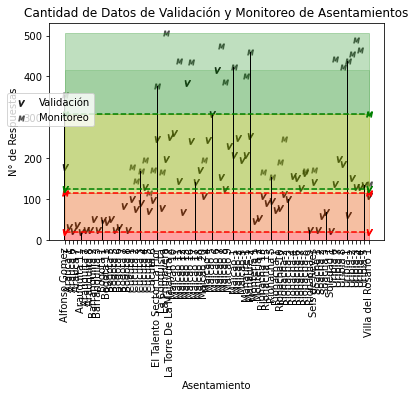

In [16]:
# Visualize number of settlements with varying number of responses stages of the validation/monitoring process

asen = stats_matrix.index
valid = stats_matrix['N° de Respuestas Validación']
monit= stats_matrix['N° de Respuestas Monitoreo']

x=asen
y=valid
w=monit

fig,ax = plt.subplots()  # a figure with a single Axes
ax.set_title("Cantidad de Datos de Validación y Monitoreo de Asentamientos")
ax.set_xlabel('Asentamiento')  # Add an x-label to the axes.
ax.set_ylabel('N° de Respuestas')  # Add a y-label to the axes.
plt.xticks(rotation=90)
#plt.yticks()

ax.scatter(x,y,label='Validación',color = (0,0,0,.75),marker='$V$')
ax.bar(x,y,color = (0,0,0,1),width=0.05)
ax.scatter(x,w,label='Monitoreo',color = (0,0,0,0.5),marker='$M$')
ax.bar(x,w,color = (0,0,0,1),width=0.05)

x_coordinates = [asen[0],asen[len(asen)-1]]

y_monit_Max = [stats_matrix['N° de Respuestas Monitoreo'].max(),stats_matrix['N° de Respuestas Monitoreo'].max()]
y_monit_mean = [stats_matrix['N° de Respuestas Monitoreo'].mean(),stats_matrix['N° de Respuestas Monitoreo'].mean()]
y_monit_threshold = [threshold_monit,threshold_monit]

y_valid_Max = [stats_matrix['N° de Respuestas Validación'].max(),stats_matrix['N° de Respuestas Validación'].max()]
y_valid_mean = [stats_matrix['N° de Respuestas Validación'].mean(),stats_matrix['N° de Respuestas Validación'].mean()]
y_valid_threshold = [threshold_valid,threshold_valid]

y_coordinates0 = [0,0]

#Validation boundary lines
plt.plot(x_coordinates,y_monit_mean,color='g',linestyle='dashed',marker='$M$')
plt.plot(x_coordinates,y_monit_threshold,color='r',linestyle='dashed',marker='$M$')

#Monitoring boundary line
plt.plot(x_coordinates,y_valid_mean,color='g',linestyle='dashed',marker='$V$')
plt.plot(x_coordinates,y_valid_threshold,color='r',linestyle='dashed',marker='$V$')

plt.rcParams["figure.figsize"] = [30, 5]

#Monitoring boundary line
ax.fill_between(x_coordinates,y_monit_Max,y_monit_mean,color='g',alpha=.25) #
ax.fill_between(x_coordinates,y_monit_threshold,y_monit_mean,color='y',alpha=.25)#
ax.fill_between(x_coordinates,y_monit_threshold,y_coordinates0,color='r',alpha=.25)#

#Validation fill
ax.fill_between(x_coordinates,y_valid_Max,y_valid_mean,color='g',alpha=.15) #
ax.fill_between(x_coordinates,y_valid_threshold,y_monit_mean,color='y',alpha=.15)#
ax.fill_between(x_coordinates,y_valid_threshold,y_coordinates0,color='r',alpha=.15)#

ax.legend(loc='center right',bbox_to_anchor=(0.15, 0.6))  # Add a legend.

plt.show()

#Why are some lines thicker than others? 

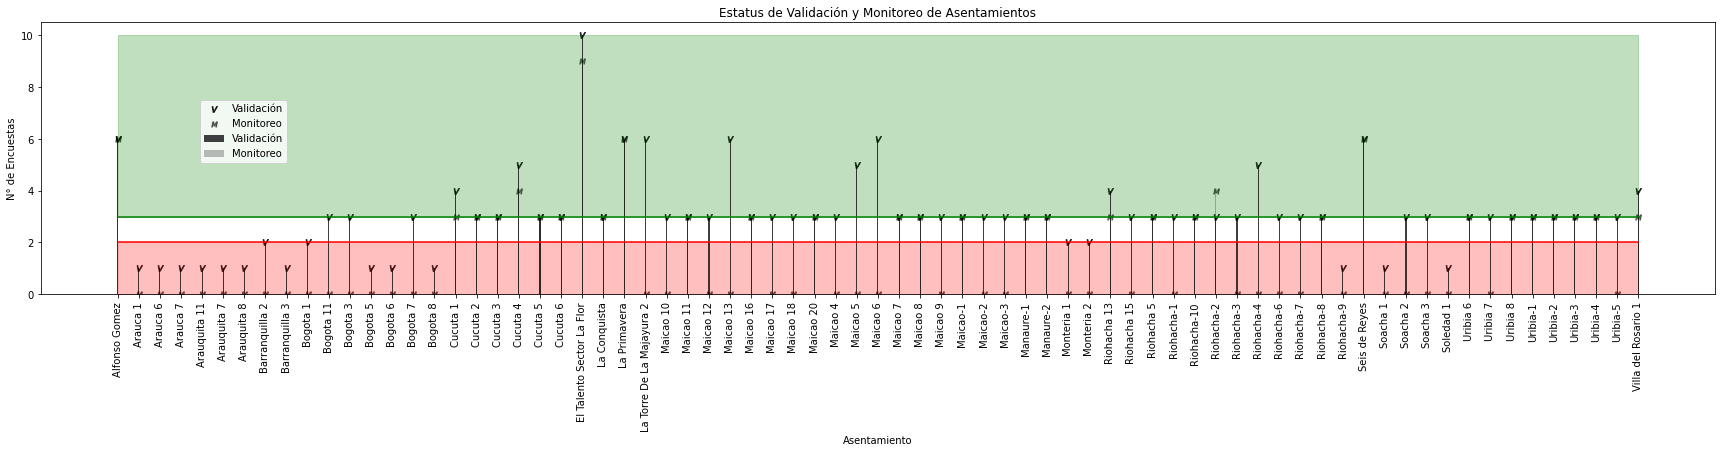

In [17]:
# Visualize number of settlements at various stages of the validation/monitoring process

asen = stats_matrix.index
valid = stats_matrix['N° de Validaciones']
monit= stats_matrix['N° de Monitoreos']

x=asen
y=valid
w=monit

fig,ax = plt.subplots()  # a figure with a single Axes
ax.set_title("Estatus de Validación y Monitoreo de Asentamientos")
ax.set_xlabel('Asentamiento')  # Add an x-label to the axes.
ax.set_ylabel('N° de Encuestas')  # Add a y-label to the axes.
plt.xticks(rotation=90)
#plt.yticks(stats_matrix['N° de Validaciones'].unique())

ax.scatter(x,y,label='Validación',color = (0,0,0,.75),marker='$V$')
ax.bar(x,y,label='Validación',color = (0,0,0,.75),width=0.05)
ax.scatter(x,w,label='Monitoreo',color = (0,0,0,0.50),marker='$M$')
ax.bar(x,w,label='Monitoreo',color = (0,0,0,0.25),width=0.05)

x_coordinates = [asen[0],asen[len(asen)-1]]
y_coordinatesMax = [stats_matrix['N° de Validaciones'].max(),stats_matrix['N° de Validaciones'].max()]
y_coordinates3 = [3,3]
y_coordinates2 = [2,2]
y_coordinates1 = [1,1]
y_coordinates0 = [0,0]

plt.plot(x_coordinates,y_coordinates3,color='g')
plt.plot(x_coordinates,y_coordinates2,color='r')

plt.rcParams["figure.figsize"] = [30, 5]

ax.fill_between(x_coordinates,y_coordinatesMax,y_coordinates3,color='g',alpha=.25) #
ax.fill_between(x_coordinates,y_coordinates2,y_coordinates0,color='r',alpha=.25)#

ax.legend(loc='center right',bbox_to_anchor=(0.15, 0.6))  # Add a legend.

plt.show()

In [18]:
stats_matrix

,Departamento,Municipio,N° de Validaciones,N° de Monitoreos,N° de Respuestas Validación,N° de Respuestas Monitoreo
Asentamiento,,,,,,
Alfonso Gomez,Norte de Santander,Cúcuta,6.0,6.0,180.0,354.0
Arauca 1,Arauca,Arauca,1.0,0.0,33.0,NaN
Arauca 6,Arauca,Arauca,1.0,0.0,23.0,NaN
Arauca 7,Arauca,Arauca,1.0,0.0,37.0,NaN
Arauquita 11,Arauca,None,1.0,0.0,20.0,NaN
...,...,...,...,...,...,...
Uribia-2,La Guajira,None,3.0,3.0,153.0,456.0
Uribia-3,La Guajira,None,3.0,3.0,129.0,488.0
Uribia-4,La Guajira,None,3.0,3.0,129.0,464.0


## Matrix Prep

In [19]:
# Generate a list of all the unique columns by removing the numbers from the original column headers and isolating unique values

############
# Validation
validES.columns

columns_no_numbers = []

for i in range(0,len(validES.columns)):
    col = validES.columns[i]
    col_no_number = ''.join([char for char in col if not char.isdigit()])
    columns_no_numbers.append(col_no_number)
    
validES.columns = columns_no_numbers

############
# Monitoring
monitES.columns

columns_no_numbers = []

for i in range(0,len(monitES.columns)):
    col = monitES.columns[i]
    col_no_number = ''.join([char for char in col if not char.isdigit()])
    columns_no_numbers.append(col_no_number)
    
monitES.columns = columns_no_numbers

In [20]:
# Automatically generate dictionaries with the unique columns and unique elements for validation and for monitoring

############
# Validation

#create empty dictionaries for validation and for monitoring,
dict_of_uq_elements_val = {}

for col in validES.columns.unique():   
    #iterate through the rows and columns 2-dimensionally,
    elementos = validES[col]

    d=[]
    
    #if the column is repeated, i.e. a DataFrame,
    #iterate two dimensionally through that DF and append elements to  the local list [d]
    if(type(validES[col])==pd.core.frame.DataFrame):
        for i in range(0,(elementos.shape[0])):
            for x in range(0,(elementos.shape[1])):
                if ((pd.isna(elementos.iloc[i][x]))==False):
                    d.append([elementos.iloc[i][x]])
    #otherwise, meaning its a series, just grab the element 
    else:
        for i in range(0,len(elementos)):
            if((pd.isna(elementos[i]))==False):
                d.append(elementos[i])
                
    #update the dictionary with the name of the column as the key and the unique elements in d as the values
    dict_of_uq_elements_val[col] = np.unique(d)
    
############
# Monitoring

dict_of_uq_elements_mon = {}

for col in monitES.columns.unique():    
    elementos = monitES[col]

    d=[]
        
    if(type(monitES[col])==pd.core.frame.DataFrame):
        for i in range(0,(elementos.shape[0])):
            for x in range(0,(elementos.shape[1])):
                if ((pd.isna(elementos.iloc[i][x]))==False):
                    d.append([elementos.iloc[i][x]])
    else:
        for i in range(0,len(elementos)):
            if((pd.isna(elementos[i]))==False):
                d.append(elementos[i])
    
    dict_of_uq_elements_mon[col] = np.unique(d)

In [21]:
# Using the two dictionaries made above for validation and monitoring,
# Generate a comprehensive Master Dictionary with all the unique columns as the keys and all the unique elements as the values

master_dict = {}
all_keys = (*dict_of_uq_elements_val.keys(), *dict_of_uq_elements_mon.keys()) #explode the keys so they are all in one list


#iterate through the keys (i.e. column name),
for key in all_keys:
    #and if its a column that is present in both dictionaries, append the exploded values to master dictionary.
    if((key in dict_of_uq_elements_val) & (key in dict_of_uq_elements_mon)):
        master_dict[key]= *dict_of_uq_elements_val.get(key),*dict_of_uq_elements_mon.get(key)
    #Otherwise, grab just the validation or monitoring value respectively
    elif(key in dict_of_uq_elements_val):
        master_dict[key]= dict_of_uq_elements_val.get(key)
    elif(key in dict_of_uq_elements_mon):
        master_dict[key]= dict_of_uq_elements_mon.get(key)
        
#since there may be some repeat elements after the merge, save only the unique values
for key in master_dict.keys():
    master_dict[key]=np.unique(master_dict.get(key))

In [22]:
master_dict.get('. Seleccione el aspecto de la comunidad que está reportando')

array(['Acueducto',
       'Agua estancada con criaderos de mosquitos o lugares donde pueden reproducirse',
       'Agua superficial (río o lago)', 'Alumbrado público', 'Andenes',
       'Barril de agua en el exterior de una vivienda',
       'Barriles de agua al frente de algunas viviendas',
       'Bomba de funcionamiento de motor',
       'Bote de basura visible desde el exterior de la vivienda',
       'Cultivo, unidad agrícola o pecuaria',
       'Elemento de información o comunicación (antenas de televisión en las viviendas, antenas de celulares,puestos de venta de periódicos o revistas)',
       'Escuela o centro educativo',
       'Espacios de compostaje de residuos de cocina',
       'Instalación pública sanitaria', 'Llave de agua comunitaria',
       'Llave de agua pública o comunal', 'Nueva construcción',
       'Otra fuente pública de agua',
       'Otros espacios de recreación social (kioskos, canchas de fútbol, etc.)',
       'Parada de autobús', 'Paradas de transporte pú

In [23]:
# Divide up the Master Dictionary keys into their respective categories to prep for the generation of various matrices

label = ['form_id',
         'submission_id',
         'locale',
         'location_id',
         'location_name',
         'location_centroid']

nombre1 = ['. ¿Sabe el nombre de este asentamiento?']
nombre2 = ['. Por favor escriba el nombre de este asentamiento']

ele_report = ['. Seleccione el aspecto de la comunidad que está reportando']

elab_report = ['. Por favor escriba en pocas palabras a qué se refiere con “otro” en la pregunta anterior.',
               '. ¿Qué alimentos y abarrotes venden dentro del establecimiento?',
               '. Los establecimientos de venta de alimentos y abarrotes son en su mayoría:',
               '. ¿Cuáles de los siguientes alimentos están disponibles dentro del establecimiento?',
               '. La calidad de los alimentos ofertados es:',
               '. ¿Qué tipos de productos observa en los cultivos o en las unidades productivas identificadas?',
               '. ¿Cuál es la capacidad de dichas cocinas comunitarias o comedores?']

foto_url = ['. Por favor tome una foto del asentamiento',
            '. Por favor tome una foto del asentamiento desde un ángulo diferente',
            '. Por favor tome una foto de una calle que muestre si está o no pavimentada',
            '. Por favor tome una foto del elemento que está reportando',
            '. Por favor tome una fotografía afuera de una vivienda o grupo de viviendas que nos permita entender mejor el tipo de material y cómo están construidas.',
            '. Por favor tome una fotografía del elemento que está reportando',
            '. Por favor tome una fotografía de un anaquel con algunos productos dentro de la tienda.']

geo_cord = ['. Díganos desde qué lugar esta reportando este elemento',
            '. Díganos desde qué lugar está reportando ete elemento']

poli_vars = ['. ¿Existe un asentamiento en este punto?',
             '. ¿Sabe desde hace cuanto comenzó el asentamiento?', 
             '. ¿Las calles están pavimentadas?',
             '. ¿El material de construcción de las viviendas parece ser improvisado?',
             '. ¿Las casas tienen puertas?',
             '. ¿Los residentes actuales del asentamiento son colombianos?',
             '. ¿Cuántas cultivos, unidades agrícolas o pecuarias hay en este asentamiento?',
             '. En términos generales ¿cómo son las condiciones de las viviendas?',
             '. ¿Qué tipos de instalaciones públicas sanitarias existen para los habitantes del asentamiento?',
             '. ¿ Cuántas construcciones (viviendas) nuevas percibe que hay?',
             '. ¿El Asentamiento cuenta con algún espacio comunitario para la transformación adecuada de los productos alimenticios para consumo, como cocinas comunitarias o comedores?',
             '. ¿Cuánto tiempo requiere para acudir a la institución o centro de salud más cercana al asentamiento?',
             '. ¿Cómo calificaría la calidad de la señal de celular en la zona?',
             '. ¿Hay alguna institución de atención en salud de carácter internacional o nacional en el municipio cercano al asentamiento?',
             '. ¿Cómo describiría el área en la que se encuentra el asentamiento?',
             '. ¿Dentro del asentamiento se percibe gente adulta mayor?',
             '. ¿Qué medidas observa se están implementando para prevenir o mitigar el COVID-?']

material = ['. ¿De qué materiales están hechas las viviendas principalmente?']

In [24]:
# We should make a matrix of census data with similar variables

#SEE: https://drive.google.com/drive/u/1/folders/1cPYuTunF1uSNcMGzNehQFrl5VZrQb0rV

##e.g. 
#V_MAT_PARED_VS1: Material predominante en paredes exteriores
#VB_ACU_VS1: Cuenta con servicio de acueducto
#VE_RECBAS_VS1: Cuenta con servicio de recolección de basura
#VF_INTERNET_VS1: Cuenta con servicio de internet (fijo o móvil)
#V_TIPO_SERSA_VS1: Tipo de servicio sanitario (inodoro)

## Element Matrix

In [25]:
#create a matrix for the unique elements reported

elem_matrix = empty_mat.copy()

for i in master_dict[ele_report[0]]:
    empty_col = (np.full(len(uq_settlements), np.nan))
    elem_matrix[i]= empty_col
    
#elem_matrix

In [26]:
# Fill matrix of elements with 1s if the element is reported, add subsequent instances of the element to that cell

for asen in elem_matrix.index: 
    loc_name = asen
    
    temp_val = validES[validES['location_name']==loc_name][ele_report[0]].dropna(axis=1)
    temp_mon = monitES[monitES['location_name']==loc_name][ele_report[0]].dropna(axis=1)

    temp_ele=[]

    for i in range(0,temp_val.shape[1]):
        for x in range(0,len(temp_val.iloc[:,i])):
            temp_ele.append(temp_val.iloc[x,(temp_val.shape[1]-1-i)])

    for i in range(0,temp_mon.shape[1]):
        for x in range(0,len(temp_mon.iloc[:,i])):
            temp_ele.append(temp_mon.iloc[x,(temp_mon.shape[1]-1-i)])

    ser = pd.Series(data=temp_ele,dtype='str')

    row_lbl = loc_name

    for i in range(0,len(temp_ele)):
        col_lbl = temp_ele[i]
        if (pd.isnull(elem_matrix.loc[row_lbl][col_lbl])==False): #if the value is not NaN,
            elem_matrix.loc[row_lbl][col_lbl] = elem_matrix.loc[row_lbl][col_lbl] + 1 #then add to the current value (will have to clarify what having multiple 1s)
        else:
            elem_matrix.loc[row_lbl][col_lbl] = 1 #otherwise (meaning the value is still NaN), just replace the NaN with a 1
    
#Create a master matrix by merging the new element matrix with the stats matrix matrix 
master_matrix=MatrixMerge(stats_matrix,elem_matrix)

#Create a subset of the master matrix for Norte de Santander
NdS_matrix = master_matrix[master_matrix['Departamento']=='Norte de Santander']

In [27]:
master_matrix
NdS_matrix

,Departamento,Municipio,N° de Validaciones,N° de Monitoreos,N° de Respuestas Validación,N° de Respuestas Monitoreo,Acueducto,Agua estancada con criaderos de mosquitos o lugares donde pueden reproducirse,Agua superficial (río o lago),Alumbrado público,...,Señales de tránsito,"Tiendas de comida, pequeños supermercados, o mercados",Tubería de agua pública o privada,Tubos de PVC que lleven aguas sucias hacia un sitio común,Tubos que llevan aguas negras hacia un sitio público,"Un cultivo, o un jardín comunitario para auto-consumo o para la venta",Un lugar en donde se observa criado de ganado,Una tienda o establecimiento de venta de abarrotes dentro del asentamiento,Una vivienda o un desarrollo de viviendas,Vendedores de agua (carrotanques privados)
Asentamiento,,,,,,,,,,,,,,,,,,,,,
Alfonso Gomez,Norte de Santander,Cúcuta,6.0,6.0,180.0,354.0,3.0,4.0,NaN,2.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,6.0,4.0,NaN
Cucuta 1,Norte de Santander,Cúcuta,4.0,3.0,100.0,180.0,3.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,NaN
Cucuta 2,Norte de Santander,Cúcuta,3.0,3.0,75.0,145.0,1.0,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.0,1.0,NaN
Cucuta 3,Norte de Santander,Cúcuta,3.0,3.0,92.0,170.0,1.0,1.0,NaN,2.0,...,NaN,NaN,2.0,NaN,1.0,NaN,NaN,3.0,NaN,NaN
Cucuta 4,Norte de Santander,Cúcuta,5.0,4.0,129.0,196.0,NaN,3.0,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,4.0,NaN,NaN,3.0,NaN
Cucuta 5,Norte de Santander,Cúcuta,3.0,3.0,72.0,116.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Cucuta 6,Norte de Santander,Cúcuta,3.0,3.0,97.0,172.0,1.0,2.0,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN
El Talento Sector La Flor,Norte de Santander,Cúcuta,10.0,9.0,246.0,376.0,1.0,1.0,NaN,1.0,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
La Conquista,Norte de Santander,Cúcuta,3.0,3.0,78.0,166.0,5.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN


## Matrix Maker Function

In [28]:
def MatrixMaker(ColType):

    # Generates an empty matrix where each cell is an empty array of the length of the number of monitorers or validators

    dict_o_dfs = []
    d={}
    temp_mat = empty_mat.copy()

    for asen in uq_settlements:

        val_asen = validES[validES['location_name']==asen].set_index('location_name').rename_axis(index = 'Asentamiento')
        mon_asen = monitES[monitES['location_name']==asen].set_index('location_name').rename_axis(index = 'Asentamiento')

        for var in ColType:

            if var in val_asen.columns:
                a=np.array(np.full(len(val_asen), np.nan))
                #print(var)
            if var in mon_asen.columns:
                a=np.array(np.full(len(mon_asen), np.nan))
                #print(var)

            d[var] = [a]

        one_row = pd.DataFrame(index=[asen],data=d)
        dict_o_dfs.append(one_row)

    frames = []

    for df in dict_o_dfs:
        frames.append(df)
    temp_mat = pd.concat(frames)
    #empty_poli_mat

    # For each settlement, 
    for asen in temp_mat.index:
        onexone = pd.DataFrame(index=[asen])

        val_asen = validES[validES['location_name']==asen].set_index('location_name').rename_axis(index = 'Asentamiento')
        mon_asen = monitES[monitES['location_name']==asen].set_index('location_name').rename_axis(index = 'Asentamiento')

        # and for each polichotomous variable,

        for var in ColType:

            if len(val_asen)>0:
                if var in val_asen.columns:
                    v = (val_asen.loc[:,var]).to_numpy()
                    onexone[var] = [v]

                    #, but make sure to remove NaN values if the cell is an array of arrays
                    if(type(onexone[var][0][0]) == np.ndarray):

                        v_clean = []
                        for i in range(0,len(v)):
                            valid_vals = [x for x in v[i] if (pd.isnull(x)==False)]
                            #, and only save the unique values
                            v_clean.append(pd.unique(valid_vals))

                        onexone[var] = [v_clean]

            if len(mon_asen)>0:
                if var in mon_asen.columns:
                    m = (mon_asen.loc[:,var]).to_numpy()
                    onexone[var] = [m]

                    #, but make sure to remove NaN values if the cell is an array of arrays
                    if(type(onexone[var][0][0]) == np.ndarray):
                        #, but make sure to remove NaN values
                        m_clean = []
                        for i in range(0,len(m)):
                            valid_vals = [x for x in m[i] if (pd.isnull(x)==False)]
                            m_clean.append(pd.unique(valid_vals))

                        onexone[var] = [m_clean]

        # fill each cell of the onexone Data Frame with an array of the three responses
        #update the whole settlement row with correct data in the poli_matrix

        temp_mat.loc[asen,:] = onexone.loc[asen,:]

    return temp_mat.rename_axis(index = 'Asentamiento')

## Polichotomous Variables Matrix

In [29]:
poli_matrix = MatrixMaker(poli_vars)
master_matrix=MatrixMerge(master_matrix,poli_matrix)
NdS_matrix = master_matrix[master_matrix['Departamento']== 'Norte de Santander']

In [30]:
master_matrix.head(3)
NdS_matrix

,Departamento,Municipio,N° de Validaciones,N° de Monitoreos,N° de Respuestas Validación,N° de Respuestas Monitoreo,Acueducto,Agua estancada con criaderos de mosquitos o lugares donde pueden reproducirse,Agua superficial (río o lago),Alumbrado público,...,. En términos generales ¿cómo son las condiciones de las viviendas?,. ¿Qué tipos de instalaciones públicas sanitarias existen para los habitantes del asentamiento?,. ¿ Cuántas construcciones (viviendas) nuevas percibe que hay?,". ¿El Asentamiento cuenta con algún espacio comunitario para la transformación adecuada de los productos alimenticios para consumo, como cocinas comunitarias o comedores?",. ¿Cuánto tiempo requiere para acudir a la institución o centro de salud más cercana al asentamiento?,. ¿Cómo calificaría la calidad de la señal de celular en la zona?,. ¿Hay alguna institución de atención en salud de carácter internacional o nacional en el municipio cercano al asentamiento?,. ¿Cómo describiría el área en la que se encuentra el asentamiento?,. ¿Dentro del asentamiento se percibe gente adulta mayor?,. ¿Qué medidas observa se están implementando para prevenir o mitigar el COVID-?
Asentamiento,,,,,,,,,,,,,,,,,,,,,
Alfonso Gomez,Norte de Santander,Cúcuta,6.0,6.0,180.0,354.0,3.0,4.0,NaN,2.0,...,[[Algunas viviendas NO se encuentran en buen e...,"[[], [Letrina], [], [], [Fosa séptica], []]","[[Entre 10 y 20], [Entre 10 y 20], [Entre 10 y...","[[No], [No], [No], [No], [De 1 a 3], [No]]",[En transporte público o automóvil más 30 minu...,"[Buena, Buena, Buena, Buena, Buena, Buena]","[Ninguna de las anteriores, Ninguna de las ant...","[Urbana, Urbana, Urbana, Urbana, Urbana, Urbana]","[Unos pocos, Unos pocos, Unos pocos, Unos poco...","[Ninguna, Ninguna, Distanciamiento Social, Dis..."
Cucuta 1,Norte de Santander,Cúcuta,4.0,3.0,100.0,180.0,3.0,3.0,NaN,NaN,...,[[La mayoría de las viviendas NO se encuentran...,"[[Fosa séptica], [], [Fosa séptica | Excusa...","[[], [Menos de 5], [Menos de 10]]","[[No], [No], [No]]",[En transporte público o automóvil menos de 20...,"[Regular, Regular, Buena]","[Ninguna de las anteriores, Ninguna de las ant...","[Urbana, Urbana, Urbana]","[Unos pocos, Unos pocos, Unos pocos]","[Ninguna, Ninguna, Ninguna]"
Cucuta 2,Norte de Santander,Cúcuta,3.0,3.0,75.0,145.0,1.0,NaN,NaN,NaN,...,"[[], [Algunas viviendas NO se encuentran en bu...","[[Letrina], [Excusado con agua corriente], [Ex...","[[Menos de 5], [], [Menos de 5]]","[[No], [No], [No]]",[En transporte público o automóvil menos de 20...,"[Regular, Buena, Buena]","[Ninguna de las anteriores, Ninguna de las ant...","[Urbana, Urbana, Urbana]","[Unos pocos, Unos pocos, Unos pocos]","[Ninguna, Ninguna, Ninguna]"
Cucuta 3,Norte de Santander,Cúcuta,3.0,3.0,92.0,170.0,1.0,1.0,NaN,2.0,...,"[[], [Algunas viviendas NO se encuentran en bu...","[[Letrina], [Letrina], []]","[[Menos de 5], [Menos de 10], [Menos de 5]]","[[No], [No], [No]]",[En transporte público o automóvilmás de una h...,"[Buena, Buena, Buena]","[Ninguna de las anteriores, Ninguna de las ant...","[Urbana, Urbana, Urbana]","[En gran cantidad, Unos pocos, En gran cantidad]","[Ninguna, Ninguna, Ninguna]"
Cucuta 4,Norte de Santander,Cúcuta,5.0,4.0,129.0,196.0,NaN,3.0,NaN,NaN,...,"[[], [La mayoría de las viviendas NO se encuen...","[[Letrina], [Letrina], [Fosa séptica], [Letrina]]","[[Menos de 5], [Menos de 5], [], [Menos de 5]]","[[No], [No], [No], [No]]",[En transporte público o automóvilmás de una h...,"[Mala, Mala, Regular, Buena]","[Ninguna de las anteriores, Ninguna de las ant...","[Rural, Rural, Urbana, Rural]","[Unos pocos, Unos pocos, Unos pocos, Unos pocos]","[Ninguna, Ninguna, Uso de guantes y tapabocas,..."
Cucuta 5,Norte de Santander,Cúcuta,3.0,3.0,72.0,116.0,1.0,NaN,NaN,NaN,...,"[[], [Algunas viviendas NO se encuentran en bu...","[[Letrina], [], [Letrina]]","[[Menos de 5], [Menos de 5], [Menos de 5]]","[[No], [De 1 a 3], [No]]",[En transporte público o automóvilmás de una h...,"[Buena, Buena, Buena]","[Ninguna de las anteriores, Ninguna de l

In [31]:
#add the ID to the element matrix array

In [32]:
responses = []

for asen in range(0,len(master_matrix.loc[:,'. ¿Existe un asentamiento en este punto?'])):
    
    response_list = master_matrix.loc[:,'. ¿Existe un asentamiento en este punto?'][asen]
    for res in range(0,len(response_list)):
        responses.append(response_list[res])

In [33]:
pd.unique(responses)

array(['Si', 'No'], dtype=object)

In [34]:
master_matrix.loc[:,'. ¿Existe un asentamiento en este punto?'][0][0]

'Si'

In [35]:
# Identify and/or remove settlements where it was identified that a settlement does not exist (part 2)

no_settl = []

for asen in master_matrix.index:
    no_settl.append('No' in master_matrix.loc[asen,'. ¿Existe un asentamiento en este punto?'])
    
master_matrix[no_settl]['. ¿Existe un asentamiento en este punto?']

cases = master_matrix[no_settl].index

cases_v = [False for i in range(len(validES))]
cases_m = [False for i in range(len(monitES))]

for idx in validES['location_name'].index:
    if validES['location_name'][idx] in cases:
        cases_v[idx] = not cases_v[idx]
    
for idx in monitES['location_name'].index:
    if monitES['location_name'][idx] in cases:
        cases_m[idx] = not cases_m[idx]
        
display(validES[cases_v])
display(monitES[cases_m])
display(master_matrix[no_settl])

#validES[cases_v].to_csv("ValidacionES_Casos_Discutidos.csv")
#monitES[cases_m].to_csv("MonitoreoES_Casos_Discutidos.csv")
#master_matrix[no_settl].to_csv("Matriz_Casos_Discutidos.csv")

,form_id,submission_id,locale,location_id,location_name,location_centroid,. Por favor tome una foto del asentamiento,. Por favor tome una foto del asentamiento desde un ángulo diferente,. Por favor tome una foto del asentamiento desde un ángulo diferente,. Por favor tome una foto del asentamiento desde un ángulo diferente,...,. Seleccione el aspecto de la comunidad que está reportando,. Díganos desde qué lugar esta reportando este elemento,. Por favor tome una foto del elemento que está reportando,. ¿El material de construcción de las viviendas parece ser improvisado?,. ¿Las casas tienen puertas?,. ¿De qué materiales están hechas las viviendas principalmente?,. Por favor tome una fotografía afuera de una vivienda o grupo de viviendas que nos permita entender mejor el tipo de material y cómo están construidas.,. ¿Sabe el nombre de este asentamiento?,. Por favor escriba el nombre de este asentamiento,. ¿Los residentes actuales del asentamiento son colombianos?
17,5306469803360256,6197002537009152,ES,130374,Bogota 11,"4.4837946214024109,-74.10295942670497",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,...,NaN,NaN,NaN,No,"Si, todas las casas tienen puertas",Latón,http://storage.googleapis.com/prod-premise-and...,No,NaN,"Si, hay más colombianos que residentes de otro..."
18,5306469803360256,6240942854242304,ES,130374,Bogota 11,"4.4837946214024109,-74.10295942670497",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,5306469803360256,6466360689557504,ES,130374,Bogota 11,"4.4837946214024109,-74.10295942670497",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,5306469803360256,5046379171020800,ES,130363,Bogota 3,"4.5026335562648967,-74.097513000695741",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,5306469803360256,5413264504913920,ES,130363,Bogota 3,"4.5026335562648967,-74.097513000695741",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,...,NaN,NaN,NaN,Si,"Si, todas las casas tienen puertas",Metal corrugado | Ladrillo,http://storage.googleapis.com/prod-premise-and...,No,NaN,"Si, hay más colombianos que residentes de otro..."
22,5306469803360256,5654205761323008,ES,130363,Bogota 3,"4.5026335562648967,-74.097513000695741",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,5306469803360256,5214018472247296,ES,129501,Maicao 12,"11.364202203602172,-72.230849906851688",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premise-and...,...,NaN,NaN,NaN,Si,"Si, todas las casas tienen puertas",Madera | Latón | Láminas de plástico | ...,http://storage.googleapis.com/prod-premise-and...,Si,Altos Villa Ines,Hay una mezcla de residentes colombianos y res...
83,5306469803360256,6474863802056704,ES,129501,Maicao 12,"11.364202203602172,-72.230849906851688",http://storage.googleapis.com/prod-premise-and...,http://storage.googleapis.com/prod-premis

,form_id,submission_id,locale,location_id,location_name,location_centroid,. Seleccione el aspecto de la comunidad que está reportando,. Díganos desde qué lugar está reportando ete elemento,. Por favor tome una fotografía del elemento que está reportando,. Los establecimientos de venta de alimentos y abarrotes son en su mayoría:,...,. ¿ Cuántas construcciones (viviendas) nuevas percibe que hay?,". ¿El Asentamiento cuenta con algún espacio comunitario para la transformación adecuada de los productos alimenticios para consumo, como cocinas comunitarias o comedores?",. ¿Cuál es la capacidad de dichas cocinas comunitarias o comedores?,. ¿Cuánto tiempo requiere para acudir a la institución o centro de salud más cercana al asentamiento?,. ¿Cómo calificaría la calidad de la señal de celular en la zona?,. ¿Hay alguna institución de atención en salud de carácter internacional o nacional en el municipio cercano al asentamiento?,. ¿Cómo describiría el área en la que se encuentra el asentamiento?,. ¿Dentro del asentamiento se percibe gente adulta mayor?,. ¿Qué medidas observa se están implementando para prevenir o mitigar el COVID-?,. ¡Hemos terminado! Gracias por participar en esta tarea.
55,6.68339E+15,6632322923495424,ES,129499,Maicao 8,"11.378544759236316,-72.26521226898106",Elemento de información o comunicación (antena...,"11.378141,-72.2649791",http://storage.googleapis.com/prod-premise-and...,NaN,...,NaN,NaN,NaN,En transporte público o automóvil menos de 20 ...,Regular,Cruz Roja Colombiana | Fundación Halu | A...,Periurbana,Unos pocos,Uso de tapabocas | Distanciamiento Social,"11.3779808,-72.2649794"
56,6683389409361920,5422518783705088,ES,129499,Maicao 8,"11.378544759236316,-72.26521226898106",Tubería de agua pública o privada,"11.3787161,-72.265228",http://storage.googleapis.com/prod-premise-and...,NaN,...,NaN,No,NaN,En transporte público o automóvil menos de 20 ...,Regular,Cruz Roja Colombiana | Fundación Halu | A...,Periurbana,Unos pocos,Uso de tapabocas | Distanciamiento Social,"11.3781882,-72.265264"
57,6.68339E+15,5451010590113792,ES,129499,Maicao 8,"11.378544759236316,-72.26521226898106",Elemento de información o comunicación (antena...,"11.3789597,-72.2651691",http://storage.googleapis.com/prod-premise-and...,NaN,...,NaN,NaN,NaN,En transporte público o automóvil menos de 20 ...,Regular,Cruz Roja Colombiana | Americares | Profam...,Periurbana,Unos pocos,Uso de tapabocas | Distanciamiento Social,"11.3781446,-72.2652853"
93,6.68339E+15,6.16556E+15,ES,129518,Uribia 8,"11.725312331915239,-72.253571318947152",Barril de agua en el exterior de una vivienda,"11.7266462,-72.256148",http://storage.googleapis.com/prod-premise-and...,NaN,...,NaN,No,NaN,En transporte público o automóvil menos de 20 ...,Regular,Ninguna de las anteriores,Periurbana,Unos pocos,Uso de tapabocas | Distanciamiento Social,"11.7253206,-72.2531945"
94,6.68339E+15,6110553183617024,ES,129518,Uribia 8,"11.725312331915239,-72.253571318947152",Bote de basura visible desde el exterior de la...,"11.7268817,-72.256295",http://storage.googleapis.com/prod-premise-and...,NaN,...,NaN,NaN,NaN,En transporte público o automóvil menos de 20 ...,Regular,Ninguna de las anteriores,Periurbana,Unos pocos,Uso de tapabocas | Distanciamiento Social,"11.7248639,-72.2531214"
92,6.68339E+15,4.63135E+15,ES,129518,Uribia 8,"11.725312331915239,-72.253571318947152",Barril de agua en el exterior de una vivienda,"11.7262581,-72.2548566",http://storage.googleapis.com/prod-premise-and...,NaN,...,NaN,NaN,NaN,En transporte público o automóvil más 30 minut...,Regular,Ninguna de las anteriores,Periurbana,Unos pocos,Uso de tapabocas,"11.7246118,-72.2526436"
95,6.68339E+15,5007738189119488,ES,129451,Uribia-1,"11.727223444540236,-72.2630030524223",Barril de agua en el exterior de una vivienda,"11.7281406,-72.2598103",http://storage.googleapis.com/prod-premise-and...,NaN,...,Menos de 5,De 1 a 3,Menos de 20 personas,En transporte público o automóvil más 30 minut...,Regular,Profamilia | Save_the_children |

,Departamento,Municipio,N° de Validaciones,N° de Monitoreos,N° de Respuestas Validación,N° de Respuestas Monitoreo,Acueducto,Agua estancada con criaderos de mosquitos o lugares donde pueden reproducirse,Agua superficial (río o lago),Alumbrado público,...,. En términos generales ¿cómo son las condiciones de las viviendas?,. ¿Qué tipos de instalaciones públicas sanitarias existen para los habitantes del asentamiento?,. ¿ Cuántas construcciones (viviendas) nuevas percibe que hay?,". ¿El Asentamiento cuenta con algún espacio comunitario para la transformación adecuada de los productos alimenticios para consumo, como cocinas comunitarias o comedores?",. ¿Cuánto tiempo requiere para acudir a la institución o centro de salud más cercana al asentamiento?,. ¿Cómo calificaría la calidad de la señal de celular en la zona?,. ¿Hay alguna institución de atención en salud de carácter internacional o nacional en el municipio cercano al asentamiento?,. ¿Cómo describiría el área en la que se encuentra el asentamiento?,. ¿Dentro del asentamiento se percibe gente adulta mayor?,. ¿Qué medidas observa se están implementando para prevenir o mitigar el COVID-?
Asentamiento,,,,,,,,,,,,,,,,,,,,,
Bogota 11,Distrito Capital,Bogotá,3.0,0.0,45.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bogota 3,Distrito Capital,Bogotá,3.0,0.0,51.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maicao 12,La Guajira,None,3.0,0.0,70.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Maicao 8,La Guajira,None,3.0,3.0,125.0,387.0,NaN,1.0,NaN,NaN,...,[[Algunas viviendas NO se encuentran en buen e...,"[[], [], []]","[[], [Menos de 10], [Menos de 5]]","[[No], [No], [No]]",[En transporte público o automóvil menos de 20...,"[Regular, Regular, Regular]",[Cruz Roja Colombiana | Fundación Halu | ...,"[Periurbana, Periurbana, Periurbana]","[Unos pocos, Unos pocos, Unos pocos]","[Uso de tapabocas | Distanciamiento Social,..."
Soacha 2,Cundinamarca,Soacha,3.0,0.0,58.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Uribia 8,La Guajira,None,3.0,3.0,185.0,424.0,NaN,3.0,NaN,NaN,...,[[La mayoría de las viviendas NO se encuentran...,"[[], [], []]","[[], [], [Menos de 5]]","[[No], [No], [No]]",[En transporte público o automóvil menos de 20...,"[Regular, Regular, Regular]","[Ninguna de las anteriores, Ninguna de las ant...","[Periurbana, Periurbana, Periurbana]","[Unos pocos, Unos pocos, Unos pocos]","[Uso de tapabocas | Distanciamiento Social,..."
Uribia-1,La Guajira,None,3.0,3.0,62.0,438.0,NaN,4.0,NaN,NaN,...,[[La mayoría de las viviendas NO se encuentran...,"[[], [], []]","[[Menos de 5], [], [Menos de 5]]","[[De 1 a 3], [De 1 a 3], [De 1 a 3]]",[En transporte público o automóvil más 30 minu...,"[Regular, Regular, Regular]","[Profamilia | Save_the_children | Unicef, ...","[Periurbana, Periurbana, Periurbana]","[Unos pocos, Unos pocos, Unos pocos]","[Uso de tapabocas, Uso de tapabocas, Uso de ta..."


## Material Matrix

In [36]:
# Create a Matrix with the instance of each material type

## Photo download and organization

https://matplotlib.org/tutorials/introductory/images.html#sphx-glr-tutorials-introductory-images-py

In [37]:
foto_matrix = MatrixMaker(foto_url)
foto_matrix.loc['Bogota 11'][0]

array(['http://storage.googleapis.com/prod-premise-android-observation-us/221decd0-c63c-4325-9417-6dbac58f607f.jpg',
       'http://storage.googleapis.com/prod-premise-android-observation-us/2521015e-2abe-424a-8340-674d585303b7.jpg',
       'http://storage.googleapis.com/prod-premise-android-observation-us/78be8960-6ca0-4ec1-b88d-263e86802b81.jpg'],
      dtype=object)

In [38]:
#BE VERY CAREFUL WITH THIS

#shutil.rmtree('Fotos')


In [ ]:
validES_elem = validES.set_index('location_name')
validES_foto = validES.set_index('location_name')

validES_elem = validES_elem['. Seleccione el aspecto de la comunidad que está reportando']
validES_foto = validES_foto['. Por favor tome una foto del elemento que está reportando']

elem_foto_pair = []

for row in range(0,len(validES_elem.index)):
    for col in range(0,len(validES_elem.columns)):
        if(pd.isnull(validES_elem.iloc[row,col])==False | pd.isnull(validES_foto.iloc[row,col])==False):
            elem_foto_pair.append([validES_elem.index[row],validES_elem.iloc[row,col],validES_foto.iloc[row,col]])

#adding elements and fotos from monitES 

monitES_elem = monitES.set_index('location_name')
monitES_foto = monitES.set_index('location_name')

monitES_elem = monitES_elem['. Seleccione el aspecto de la comunidad que está reportando']
monitES_foto = monitES_foto['. Por favor tome una fotografía del elemento que está reportando']

for row in range(0,len(monitES_elem.index)):
    for col in range(0,len(monitES_elem.columns)):
        if(pd.isnull(monitES_elem.iloc[row,col])==False | pd.isnull(monitES_foto.iloc[row,col])==False):
            elem_foto_pair.append([monitES_elem.index[row],monitES_elem.iloc[row,col],monitES_foto.iloc[row,col]])    

In [ ]:
#Automatically create a folder for each settlement and with that for each element

#create a Fotos folder
#new_dir = pathlib.Path('Fotos') 
#new_dir.mkdir(parents=True, exist_ok=False)

for i in range(0,len(elem_foto_pair)-1):
    asen = elem_foto_pair[i][0]
    elem = elem_foto_pair[i][1]
    foto = elem_foto_pair[i][2]

    set_folder_name = ('Fotos: '+asen + ' Elementos')
    
    set_fold = pathlib.Path('Fotos',set_folder_name) #For each settlement, create a settlement fotos folder
    set_fold.mkdir(parents=True, exist_ok=True)

    ele_fold = pathlib.Path(set_fold,elem) #For each element, create a settlement element fotos folder
    ele_fold.mkdir(parents=True, exist_ok=True)

    foto_name = asen + ': ' + elem + str(i) + '.jpg'

    file_path = ele_fold / foto_name
    urllib.request.urlretrieve(foto, file_path)

    #image = io.imread(foto)
    #plt.imshow(image)
    #plt.show()
    

In [ ]:
# Add the photos of the settlement and the paved streets to the respective folder

foto_matrix

asentamiento = ['. Por favor tome una foto del asentamiento','. Por favor tome una foto del asentamiento desde un ángulo diferente']

calle = ['. Por favor tome una foto de una calle que muestre si está o no pavimentada']

material = ['. Por favor tome una fotografía afuera de una vivienda o grupo de viviendas que nos permita entender mejor el tipo de material y cómo están construidas.']


In [ ]:
# Add elements and fotos from validES and monitES 

validES_elem = validES.set_index('location_name')
validES_foto = validES.set_index('location_name')

validES_elem = validES_elem['. Seleccione el aspecto de la comunidad que está reportando']
validES_foto = validES_foto['. Por favor tome una foto del elemento que está reportando']

monitES_elem = monitES.set_index('location_name')
monitES_foto = monitES.set_index('location_name')

monitES_elem = monitES_elem['. Seleccione el aspecto de la comunidad que está reportando']
monitES_foto = monitES_foto['. Por favor tome una fotografía del elemento que está reportando']



# Create another array with the settlement, element, foto url, and an empty array for classifying

elem_foto_pair_validation = []

X_asen = []
X_foto = []
y_elem = []
y_validation = []

for row in range(0,len(validES_elem.index)):
    for col in range(0,len(validES_elem.columns)):
        if(pd.isnull(validES_elem.iloc[row,col])==False | pd.isnull(validES_foto.iloc[row,col])==False):
            elem_foto_pair_validation.append([validES_elem.index[row],
                                   validES_elem.iloc[row,col],
                                   validES_foto.iloc[row,col],
                                   []])
        foto_url = validES_foto.iloc[row,col]
        #if(pd.isnull(foto_url)==False):
            #X_foto.append(io.imread(foto_url))
        X_foto.append(foto_url)
        X_asen.append(validES_elem.index[row])
        y_elem.append(validES_elem.iloc[row,col])
        y_validation.append([])
            
            
for row in range(0,len(monitES_elem.index)):
    for col in range(0,len(monitES_elem.columns)):
        if(pd.isnull(monitES_elem.iloc[row,col])==False | pd.isnull(monitES_foto.iloc[row,col])==False):
            elem_foto_pair_validation.append([monitES_elem.index[row],
                                              monitES_elem.iloc[row,col],
                                              monitES_foto.iloc[row,col],
                                              []])
        foto_url = monitES_foto.iloc[row,col]
        #if(pd.isnull(foto_url)==False): #this should already be taken care of...
        #    X_foto.append(io.imread(foto_url)) 
        X_foto.append(foto_url)
        X_asen.append(monitES_elem.index[row])
        y_elem.append(monitES_elem.iloc[row,col])
        y_validation.append([])
            



In [ ]:
elem_foto_pair_validation[0:6] #display just a few

In [ ]:
# Show the user one random photo at a time,
# and prompt to verify that the contents of the photo match the surveyor's response


for i in range(0,len(elem_foto_pair_validation)-1):
    x=(random.randint(0,len(elem_foto_pair_validation)-1))
    asen = elem_foto_pair_validation[x][0]
    elem = elem_foto_pair_validation[x][1]
    foto = elem_foto_pair_validation[x][2]
    validation = elem_foto_pair_validation[x][3]
    
    
    image = io.imread(foto)
    plt.imshow(image)
    plt.show()
    
   
    print("¿Es esta fota una fota de lo siguiente: ")
    print("\t{" + elem + "} ?")
    
    
    v = input("Deja el espacio en blanco y dale a 'Enter' si deseas parar de verificar.\nIngresa {'Si', 'No',o 'No se'}:")
    elem_foto_pair_validation[x][3].append(v)
    
    y_validation[x] = v
    
    if v== '':
        break
        
    
#save the verification

## Ignore below (see IMG_Validation_NeuralNetwork workbook for more work with photos)

In [ ]:
# Create another array with the settlement, element, foto url, and an empty array for classifying

elem_foto_pair_validation = []

for row in range(0,len(validES_elem.index)):
    for col in range(0,len(validES_elem.columns)):
        if(pd.isnull(validES_elem.iloc[row,col])==False | pd.isnull(validES_foto.iloc[row,col])==False):
            elem_foto_pair_validation.append([validES_elem.index[row],
                                   validES_elem.iloc[row,col],
                                   validES_foto.iloc[row,col],
                                   []])
            
            
for row in range(0,len(monitES_elem.index)):
    for col in range(0,len(monitES_elem.columns)):
        if(pd.isnull(monitES_elem.iloc[row,col])==False | pd.isnull(monitES_foto.iloc[row,col])==False):
            elem_foto_pair_validation.append([monitES_elem.index[row],
                                              monitES_elem.iloc[row,col],
                                              monitES_foto.iloc[row,col],
                                              []])
            

            
            
            

In [ ]:
# Show the user one random photo at a time,
# and prompt to verify that the contents of the photo match the surveyor's response

for i in range(0,len(elem_foto_pair_validation)-1):
    x=(random.randint(0,len(elem_foto_pair_validation)-1))
    asen = elem_foto_pair_validation[x][0]
    elem = elem_foto_pair_validation[x][1]
    foto = elem_foto_pair_validation[x][2]
    validation = elem_foto_pair_validation[x][3]
    
    
    image = io.imread(foto)
    plt.imshow(image)
    plt.show()
    
    print("¿Es esta fota una fota de lo siguiente: ")
    print("\t{" + elem + "} ?")
    v = input('Si, No, o No se:')
    elem_foto_pair_validation[x][3].append(v)
    if v == '':
        break
    
#save the verification

In [ ]:
elem_foto_pair_validation

In [ ]:
#import Tkinter
#import tkMessageBox

#top = Tkinter.Tk()

#def helloCallBack():
#   tkMessageBox.showinfo( "Hello Python", "Hello World")

#B = Tkinter.Button(top, text ="Hello", command = helloCallBack)

#B.pack()
#top.mainloop()



## messing around down there...

In [ ]:
sing_set_fotos = foto_matrix.head(1)

In [ ]:
for foto_col in sing_set_fotos.columns:
    
    for i in range(0,len((sing_set_fotos.loc[:,foto_col]))):
        #print(str(type(sing_set_fotos[foto_col][0])))
        cell_type = type(sing_set_fotos[foto_col][i])
        if(cell_type==np.ndarray):
            #print(sing_set_fotos.loc[:,foto_col][i])
            print(str(cell_type) + " " + foto_col)
        if(cell_type==list):
            #print(sing_set_fotos.loc[:,foto_col][i])
            print(str(cell_type) + " " + foto_col)
      
    #print(sing_set_fotos.loc[:,foto_col])

In [ ]:


# Create a folder
for asen in foto_matrix.index:
    for foto_col in foto_matrix.columns:
            folder_name = ('Fotos: '+asen+" "+ foto_col)#[len(foto_col)-25:len(foto_col)])

            new_dir = pathlib.Path('Fotos',folder_name) #For each settlement, create a Fotos folder
            new_dir.mkdir(parents=True, exist_ok=True)

            #for foto in sing_set_fotos.loc[asen,foto_col]:
                #url=foto
                #uq_code = url[len(url)-40:len(url)-5]
                #foto_name = asen+" "+uq_code+'.jpg'

                # You have to make a file inside the new directory
                #file_path = new_dir / foto_name
                #urllib.request.urlretrieve(url, file_path)

    

In [ ]:
foto_matrix.head(3)

In [ ]:
#display image inline from directory
img = mpimg.imread('Fotos/Fotos: 6 de Reyes/6 de Reyes. Por favor tome una foto del asentamiento0.jpg')
imgplot = plt.imshow(img)

In [ ]:
#display image inline from URL
image = io.imread(url)
plt.imshow(image)
plt.show()